In [1]:
from gensn.distributions import TrainableDistributionAdapter, Joint
from gensn.variational import ELBOMarginal
from gensn.parameters import TransformedParameter, PositiveDiagonal, Covariance
from gensn.flow import FlowDistribution
import gensn.transforms.invertible as T
import gensn.distributions as G
import torch.distributions as D

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
from torch import nn
from torch.optim import Adam
from torch.distributions import Normal, MultivariateNormal

## Example usage: learn Normal distribution

### Learn only the mean

In [4]:
# make the mean & std both learnable
# std (scale) is set to be square of a parameter, thus ensuring positive value
normal = TrainableDistributionAdapter(Normal, 
                               loc=nn.Parameter(torch.Tensor([0.0])), 
                               scale=torch.Tensor([2.0]))

In [5]:
normal

TrainableDistributionAdapter(
  distribution_class=<class 'torch.distributions.normal.Normal'>, loc=Parameter containing:
  tensor([0.], requires_grad=True), scale=tensor([2.])
)

In [ ]:
normal.state_dict()

OrderedDict([('loc', tensor([0.])), ('scale', tensor([2.]))])

In [297]:
list(normal.parameters())

[Parameter containing:
 tensor([0.], requires_grad=True)]

In [298]:
# setup target normal distribution to learn
target = Normal(torch.Tensor([5.0]), torch.Tensor([2.0]))

In [299]:
optim = Adam(normal.parameters(), lr=0.5)

In [300]:
for i in range(1000):
    optim.zero_grad()
    targets = target.sample((100,))
    nlogp = -normal(targets).mean()
    mean = normal.loc.detach()
    if (i+1) % 100 == 0:
        print(f'Neg logP: {nlogp}, mean={mean}')
    nlogp.backward()
    optim.step()

Neg logP: 2.1345815658569336, mean=tensor([4.9067])
Neg logP: 2.092252492904663, mean=tensor([4.9593])
Neg logP: 2.180840253829956, mean=tensor([4.9536])
Neg logP: 2.003469467163086, mean=tensor([5.0459])
Neg logP: 2.1333930492401123, mean=tensor([4.8133])
Neg logP: 2.128748655319214, mean=tensor([4.9254])
Neg logP: 2.145400285720825, mean=tensor([5.2278])
Neg logP: 2.060579776763916, mean=tensor([5.1595])
Neg logP: 2.141294479370117, mean=tensor([4.6781])
Neg logP: 2.0860490798950195, mean=tensor([5.2226])


### Learn both mean and stdev

In [301]:
# make the mean & std both learnable
# std (scale) is set to be square of a parameter, thus ensuring positive value
normal = TrainableDistributionAdapter(Normal, 
                               loc=nn.Parameter(torch.Tensor([0.0])), 
                               scale=TransformedParameter(torch.Tensor([1.0]), lambda x: x**2))

In [302]:
# setup target normal distribution to learn
target = Normal(torch.Tensor([5]), torch.Tensor([8]))

In [303]:
optim = Adam(normal.parameters(), lr=1.0)

In [304]:
for i in range(1000):
    optim.zero_grad()
    targets = target.sample((100,))
    nlogp = -normal(targets).mean()
    mean = normal.loc.detach()
    std = normal.scale.value.detach()
    if (i+1) % 100 == 0:
        print(f'Neg logP: {nlogp}, mean={mean}, std={std}')
    nlogp.backward()
    optim.step()

Neg logP: 4.561710834503174, mean=tensor([6.3187]), std=tensor([37.1558])
Neg logP: 3.731532573699951, mean=tensor([5.9032]), std=tensor([13.8333])
Neg logP: 3.6473095417022705, mean=tensor([5.0143]), std=tensor([7.9314])
Neg logP: 3.544020414352417, mean=tensor([5.2361]), std=tensor([8.0676])
Neg logP: 3.68112850189209, mean=tensor([4.9203]), std=tensor([8.0663])
Neg logP: 3.4638118743896484, mean=tensor([5.1734]), std=tensor([8.0283])
Neg logP: 3.3631904125213623, mean=tensor([4.7934]), std=tensor([7.8024])
Neg logP: 3.4311606884002686, mean=tensor([4.7605]), std=tensor([8.0656])
Neg logP: 3.4221224784851074, mean=tensor([5.1094]), std=tensor([7.6285])
Neg logP: 3.4728546142578125, mean=tensor([4.9464]), std=tensor([7.6277])


### Learn both mean and stdev (same as above, but specified positionally)

In [305]:
# make the mean & std both learnable
# std (scale) is set to be square of a parameter, thus ensuring positive value
normal = TrainableDistributionAdapter(Normal, 
                               nn.Parameter(torch.Tensor([0.0])), 
                               TransformedParameter(torch.Tensor([1.0]), lambda x: x**2))

In [306]:
# setup target normal distribution to learn
target = Normal(torch.Tensor([5]), torch.Tensor([8]))

In [307]:
optim = Adam(normal.parameters(), lr=1.0)

In [308]:
for i in range(1000):
    optim.zero_grad()
    targets = target.sample((100,))
    nlogp = -normal(targets).mean()
    mean = normal._arg0.detach()
    std = normal._arg1.value.detach()
    if (i+1) % 100 == 0:
        print(f'Neg logP: {nlogp}, mean={mean}, std={std}')
    nlogp.backward()
    optim.step()

Neg logP: 4.549066543579102, mean=tensor([6.3602]), std=tensor([36.8527])
Neg logP: 3.677386522293091, mean=tensor([5.8111]), std=tensor([12.8413])
Neg logP: 3.543503761291504, mean=tensor([5.1272]), std=tensor([7.8402])
Neg logP: 3.461636543273926, mean=tensor([4.8776]), std=tensor([7.7744])
Neg logP: 3.567099094390869, mean=tensor([4.9993]), std=tensor([8.1482])
Neg logP: 3.4323456287384033, mean=tensor([5.0297]), std=tensor([8.1427])
Neg logP: 3.405374765396118, mean=tensor([4.9539]), std=tensor([7.8439])
Neg logP: 3.460333824157715, mean=tensor([5.2358]), std=tensor([7.9700])
Neg logP: 3.490623712539673, mean=tensor([5.1611]), std=tensor([8.1306])
Neg logP: 3.4389190673828125, mean=tensor([4.7474]), std=tensor([7.7871])


# Conditional case

## Simple conditioning

Now let us learn more complex relationship $p(z|x)$. Specifically, let $p(z|x) = \mathcal{N}(f(x), \sigma^2)$.

For simplicity, we'll assume a simple linear mapping for $f(x)$

Prepare data generator

In [309]:
def get_batch(batch_size):
    x = torch.rand((batch_size, 1))
    mu = -5 * x + 9
    y = Normal(mu, scale=7).sample((batch_size,))
    return x, y

Set up the conditional network:

In [310]:
# make the mean & std both learnable
# std (scale) is set to be abs of a parameter, thus ensuring positive value
normal = TrainableDistributionAdapter(Normal, 
                               loc=nn.Linear(1, 1), 
                               scale=TransformedParameter(torch.Tensor([1.0]), torch.abs))

In [311]:
optim = Adam(normal.parameters(), lr=1.0)

In [312]:
for i in range(1000):
    optim.zero_grad()
    x, y = get_batch(100)
    nlogp = -normal(y, cond=x).mean()
    params = {k:v.detach() for k,v in normal.state_dict().items()}
    if (i+1) % 100 == 0:
        print(f'Neg logP: {nlogp}, params={params}')
    nlogp.backward()
    optim.step()

Neg logP: 3.4092979431152344, params={'loc.weight': tensor([[1.9318]]), 'loc.bias': tensor([5.1510]), 'scale.parameter': tensor([7.9295])}
Neg logP: 3.3908944129943848, params={'loc.weight': tensor([[-0.3104]]), 'loc.bias': tensor([6.3577]), 'scale.parameter': tensor([7.6660])}
Neg logP: 3.380882740020752, params={'loc.weight': tensor([[-2.3639]]), 'loc.bias': tensor([7.4960]), 'scale.parameter': tensor([7.3816])}
Neg logP: 3.3698973655700684, params={'loc.weight': tensor([[-3.7433]]), 'loc.bias': tensor([8.3018]), 'scale.parameter': tensor([7.1689])}
Neg logP: 3.367433547973633, params={'loc.weight': tensor([[-4.5504]]), 'loc.bias': tensor([8.7046]), 'scale.parameter': tensor([7.0584])}
Neg logP: 3.3590378761291504, params={'loc.weight': tensor([[-4.8427]]), 'loc.bias': tensor([8.9199]), 'scale.parameter': tensor([7.0086])}
Neg logP: 3.3587515354156494, params={'loc.weight': tensor([[-4.9707]]), 'loc.bias': tensor([8.9731]), 'scale.parameter': tensor([7.0025])}
Neg logP: 3.36746597290

## One network with multiple outputs (returning dict):

In [313]:
class NormalParams(nn.Module):
    def __init__(self):
        super().__init__()
        self.core = nn.Linear(1, 2)
        
    def forward(self, x):
        vals = self.core(x)
        #loc, scale = vals.split((1,1), dim=1)
        return dict(loc=vals[:,0:1], scale=(vals[:, 1:])**2)
        #return dict(loc=loc, scale=scale**2)

In [314]:
def get_batch(batch_size):
    x = torch.rand((batch_size, 1))
    mu = -5 * x + 9
    scale = (3 * x + 1)
    model = Normal(mu, scale=scale)
    y = model.sample((batch_size,))
    return x, y, model.log_prob(y)

In [315]:
# make the mean & std both learnable
# std (scale) is set to be square of a parameter, thus ensuring positive value
normal = TrainableDistributionAdapter(Normal, _parameters=NormalParams())

In [316]:
optim = Adam(normal.parameters(), lr=1)

In [317]:
for i in range(1000):
    optim.zero_grad()
    x, y, true_logp = get_batch(100)
    nlogp = -normal(y, cond=x).mean()
    params = {k:v.detach() for k,v in normal.state_dict().items()}
    if i % 100 == 0:
        print(f'Neg logP: {nlogp:0.3f} (gt={-true_logp.mean():0.3f}), params={params}')
    nlogp.backward()
    optim.step()

Neg logP: 16035.315 (gt=2.335), params={'parameter_generator.core.weight': tensor([[-0.5103],
        [-0.7743]]), 'parameter_generator.core.bias': tensor([-0.8335, -0.1008])}
Neg logP: 5.351 (gt=2.242), params={'parameter_generator.core.weight': tensor([[ 5.5012],
        [-6.7766]]), 'parameter_generator.core.bias': tensor([ 5.1741, -6.1058])}
Neg logP: 5.402 (gt=2.278), params={'parameter_generator.core.weight': tensor([[ 5.5011],
        [-6.7711]]), 'parameter_generator.core.bias': tensor([ 5.1744, -6.1055])}
Neg logP: 5.422 (gt=2.308), params={'parameter_generator.core.weight': tensor([[ 5.5005],
        [-6.7635]]), 'parameter_generator.core.bias': tensor([ 5.1745, -6.1047])}
Neg logP: 5.420 (gt=2.314), params={'parameter_generator.core.weight': tensor([[ 5.4999],
        [-6.7542]]), 'parameter_generator.core.bias': tensor([ 5.1746, -6.1038])}
Neg logP: 5.332 (gt=2.237), params={'parameter_generator.core.weight': tensor([[ 5.4991],
        [-6.7433]]), 'parameter_generator.core

## One network with multiple outputs (returning positionally):

In [318]:
class NormalParams(nn.Module):
    def __init__(self):
        super().__init__()
        self.core = nn.Linear(1, 2)
        
    def forward(self, x):
        vals = self.core(x)
        #loc, scale = vals.split((1,1), dim=1)
        return vals[:,0:1], (vals[:, 1:])**2
        #return dict(loc=loc, scale=scale**2)

In [319]:
def get_batch(batch_size):
    x = torch.rand((batch_size, 1))
    mu = -5 * x + 9
    scale = (3 * x + 1)
    model = Normal(mu, scale=scale)
    y = model.sample((batch_size,))
    return x, y, model.log_prob(y)

In [320]:
# make the mean & std both learnable
# std (scale) is set to be square of a parameter, thus ensuring positive value
normal = TrainableDistributionAdapter(Normal, _parameters=NormalParams())

In [321]:
optim = Adam(normal.parameters(), lr=1)

In [322]:
for i in range(1000):
    optim.zero_grad()
    x, y, true_logp = get_batch(100)
    nlogp = -normal(y, cond=x).mean()
    params = {k:v.detach() for k,v in normal.state_dict().items()}
    if i % 100 == 0:
        print(f'Neg logP: {nlogp:0.3f} (gt={-true_logp.mean():0.3f}), params={params}')
    nlogp.backward()
    optim.step()

Neg logP: 36987420.000 (gt=2.236), params={'parameter_generator.core.weight': tensor([[ 0.1736],
        [-0.5506]]), 'parameter_generator.core.bias': tensor([-0.5053,  0.3585])}
Neg logP: 5.217 (gt=2.164), params={'parameter_generator.core.weight': tensor([[6.1788],
        [5.4546]]), 'parameter_generator.core.bias': tensor([5.4999, 6.3637])}
Neg logP: 5.329 (gt=2.306), params={'parameter_generator.core.weight': tensor([[6.1791],
        [5.4549]]), 'parameter_generator.core.bias': tensor([5.5002, 6.3640])}
Neg logP: 5.366 (gt=2.335), params={'parameter_generator.core.weight': tensor([[6.1791],
        [5.4549]]), 'parameter_generator.core.bias': tensor([5.5002, 6.3640])}
Neg logP: 5.346 (gt=2.324), params={'parameter_generator.core.weight': tensor([[6.1791],
        [5.4549]]), 'parameter_generator.core.bias': tensor([5.5002, 6.3640])}
Neg logP: 5.271 (gt=2.237), params={'parameter_generator.core.weight': tensor([[6.1791],
        [5.4549]]), 'parameter_generator.core.bias': tensor(

# Test sampling and joint

In [323]:
prior = TrainableDistributionAdapter(Normal, loc=nn.Parameter(torch.Tensor([5])),
                                     scale=torch.Tensor([2]))

linear = nn.Linear(1, 1)
linear.weight.data = torch.Tensor([[-2]])
linear.bias.data = torch.Tensor([6])
conditional = TrainableDistributionAdapter(Normal, loc=linear, scale=torch.Tensor([1]))

# create a joint distribution out of prior and conditional
joint = Joint(prior, conditional)

In [324]:
x, y = joint.sample((10000,))

Should be 5, 2

In [325]:
x.mean(), x.std()

(tensor(4.9949), tensor(1.9826))

Should be -4, 4

In [326]:
y.mean(), y.std()

(tensor(-4.0185), tensor(4.0972))

# Simulating a multi-dimensional joint distribution

### Define the ground-truth generative model

In [327]:
n_latents = 5
gt_prior = TrainableDistributionAdapter(MultivariateNormal, 
                                        torch.ones([n_latents]),
                                        torch.eye(n_latents))

n_obs = 10
features = torch.randn([n_latents, n_obs])

feature_map = nn.Linear(n_latents, n_obs)
feature_map.weight.data = features.T
feature_map.bias.data.zero_()

gt_conditional = TrainableDistributionAdapter(MultivariateNormal,
                                              feature_map,
                                              torch.eye(n_obs))

gt_joint = Joint(gt_prior, gt_conditional)

### Now prepare a trainable model

class Covariance(nn.Module):
    def __init__(self, n_dim):
        

In [328]:
n_latents = 5
model_prior = TrainableDistributionAdapter(MultivariateNormal, 
                                        nn.Parameter(torch.zeros([n_latents])),
                                        PositiveDiagonal(n_latents))

n_obs = 10
features = torch.randn([n_latents, n_obs])

feature_map = nn.Linear(n_latents, n_obs)
#feature_map.weight.data = features.T
#feature_map.bias.data.zero_()

model_conditional = TrainableDistributionAdapter(MultivariateNormal,
                                              feature_map,
                                              torch.eye(n_obs))

model_joint = Joint(model_prior, model_conditional)

### Go ahead and train the joint model

In [329]:
optim = Adam(model_joint.parameters(), lr=0.5)

In [330]:
for i in range(1000):
    optim.zero_grad()
    samples = gt_joint.sample((100,))
    gt_logl = gt_joint.log_prob(*samples).mean()
    model_logl = model_joint.log_prob(*samples).mean()
    if i % 100 == 0:
        print(f'Model logp: {model_logl:.3f} / GT logp: {gt_logl:.3f}')
    (-model_logl).backward()
    optim.step()

Model logp: -72.364 / GT logp: -21.072
Model logp: -21.743 / GT logp: -21.511
Model logp: -21.952 / GT logp: -21.396
Model logp: -21.664 / GT logp: -20.948
Model logp: -21.468 / GT logp: -21.188
Model logp: -21.607 / GT logp: -21.107
Model logp: -21.612 / GT logp: -21.372
Model logp: -22.217 / GT logp: -21.679
Model logp: -21.954 / GT logp: -21.324
Model logp: -21.714 / GT logp: -21.061


Checking the learned parameters

In [331]:
model_joint.prior._arg1()

tensor([[1.1548, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7863, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7180, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.1459, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.4096]], grad_fn=<DiagBackward0>)

In [332]:
model_joint.prior.state_dict()

OrderedDict([('_arg0', tensor([0.9010, 1.0821, 1.0691, 1.0065, 0.9018])),
             ('_arg1.D',
              tensor([-1.0746,  0.8867, -0.8473,  1.0705,  1.1873]))])

In [333]:
model_joint.conditional.state_dict()

OrderedDict([('_arg1',
              tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])),
             ('_arg0.weight',
              tensor([[ 2.9354, -0.4846, -0.6591,  0.9990,  0.8338],
                      [-0.0035, -1.2011, -0.2397,  0.3896,  0.5619],
                      [ 1.1625, -0.9961, -0.8574, -0.2439, -1.1102],
                      [-0.7637, -2.2235, -0.2076,  0.6137,  0.1408],
                      [ 1.18

## Compute the posterior distriubtion via ELBO

First, we'll train the posterior for the ground-truth model, using ELBO

In [334]:
# prepare a posterior distribution
features = torch.randn([n_obs, n_latents])

linear_map = nn.Linear(n_obs, n_latents)

posterior = TrainableDistributionAdapter(MultivariateNormal,
                                              linear_map,
                                              Covariance(n_latents, rank=5, eps=1e-6))


In [335]:
elbo_x = ELBOMarginal(gt_joint, posterior)

# only training the posterior
optim = Adam(posterior.parameters(), lr=1e-2)

In [336]:
z_sample, x_sample = gt_joint.sample((1000,))

for i in range(1000):
    optim.zero_grad()
    elbo = elbo_x(x_sample).mean()
    if i % 100 == 0:
        print(f'Model elbo: {elbo:.3f}')
    (-elbo).backward()
    optim.step()

Model elbo: -169.007
Model elbo: -28.528
Model elbo: -20.591
Model elbo: -19.647
Model elbo: -19.541
Model elbo: -19.542
Model elbo: -19.545
Model elbo: -19.537
Model elbo: -19.534
Model elbo: -19.539


### Evaluate the posterior
Here we will evaluate how good the posterior is (roughly) by sampling $\hat{z}$ from the posterior $p(z|x)$ and evaluate the expected $\log p(\hat{z}, x)$.
If $\hat{z}$ approximates the true distribution over $z$, then $\log p(\hat{z}, x)$ will closely apprximate the expected $\log p(z, x)$, which is negative of entropy.

In [337]:
z_sample, x_sample = gt_joint.sample((1000,))

In [338]:
# ground-truth negative entropy
gt_joint.log_prob(z_sample, x_sample).mean()

tensor(-21.2298, grad_fn=<MeanBackward0>)

In [339]:
# sample from the trained posterior
z_hat = posterior.sample(cond=x_sample)

# 
# negative entropy of the approximation
gt_joint.log_prob(z_hat, x_sample).mean()

tensor(-21.2033, grad_fn=<MeanBackward0>)

## Compute the posterior distriubtion via direct fit to samples

Now, we'll train the posterior for the ground-truth model by training directly on the samples

In [340]:
# prepare a posterior distribution
features = torch.randn([n_obs, n_latents])

linear_map = nn.Linear(n_obs, n_latents)

posterior = TrainableDistributionAdapter(MultivariateNormal,
                                              linear_map,
                                              Covariance(n_latents, rank=5, eps=1e-6))


In [341]:
# only training the posterior
optim = Adam(posterior.parameters(), lr=1e-2)

In [342]:

for i in range(1000):
    optim.zero_grad()
    z_sample, x_sample = gt_joint.sample((100,))
    logp = posterior.log_prob(z_sample, cond=x_sample).mean()
    if i % 100 == 0:
        print(f'LogP: {logp:.3f}')
    (-logp).backward()
    optim.step()

LogP: -96.389
LogP: -7.519
LogP: -6.790
LogP: -6.285
LogP: -5.545
LogP: -4.548
LogP: -4.053
LogP: -3.832
LogP: -3.490
LogP: -3.431


### Evaluate the posterior
Here we will evaluate how good the posterior is (roughly) by sampling $\hat{z}$ from the posterior $p(z|x)$ and evaluate the expected $\log p(\hat{z}, x)$.
If $\hat{z}$ approximates the true distribution over $z$, then $\log p(\hat{z}, x)$ will closely apprximate the expected $\log p(z, x)$, which is negative of entropy.

In [343]:
z_sample, x_sample = gt_joint.sample((1000,))

In [344]:
# ground-truth negative entropy
gt_joint.log_prob(z_sample, x_sample).mean()

tensor(-21.1685, grad_fn=<MeanBackward0>)

In [345]:
# sample from the trained posterior
z_hat = posterior.sample(cond=x_sample)

# 
# negative entropy of the approximation
gt_joint.log_prob(z_hat, x_sample).mean()

tensor(-52.3061, grad_fn=<MeanBackward0>)

## Normalizing flow

Here we now experiment learning normalizing flow distribution. We will learn a Laplace distribution by flowing a normal distribution

In [25]:
target_distr = G.TrainableDistributionAdapter(D.Laplace, loc=torch.Tensor([3]), scale=torch.Tensor([2]))
#target_distr = G.TrainableDistributionAdapter(D.Exponential, rate=torch.Tensor([0.1]))

In [26]:
target_samples = target_distr.sample((1000,))

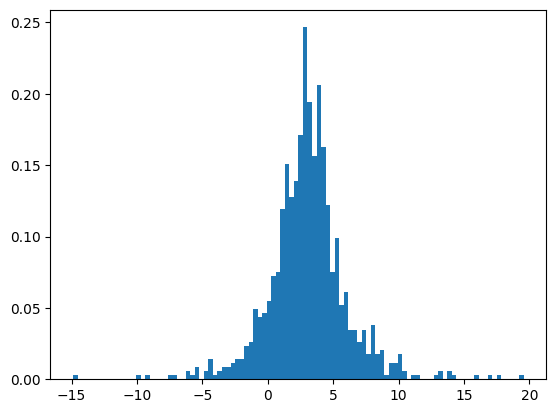

In [202]:
plt.hist(target_samples.flatten(), bins=100, density=True);

In [28]:
target_logL = target_distr.log_prob(target_samples).mean()

We first try to learn and fit Gaussian distribution against these samples

In [29]:
model_gaussian = G.IndependentNormal(nn.Parameter(torch.Tensor([0])), TransformedParameter(torch.Tensor([1.0]), lambda x: x**2 + 1e-12))

In [30]:
optim = Adam(model_gaussian.parameters(), lr=1.0)

In [31]:
for _ in range(1000):
    optim.zero_grad()
    nll = -model_gaussian(target_samples).mean()
    print(f'Model LL: {-nll}, Target LL: {target_logL}')
    nll.backward()
    optim.step()

Model LL: -9.088858604431152, Target LL: -2.3562936782836914
Model LL: -2.6601176261901855, Target LL: -2.3562936782836914
Model LL: -2.967880964279175, Target LL: -2.3562936782836914
Model LL: -3.2613935470581055, Target LL: -2.3562936782836914
Model LL: -3.4820713996887207, Target LL: -2.3562936782836914
Model LL: -3.650675058364868, Target LL: -2.3562936782836914
Model LL: -3.7829349040985107, Target LL: -2.3562936782836914
Model LL: -3.888895034790039, Target LL: -2.3562936782836914
Model LL: -3.9750962257385254, Target LL: -2.3562936782836914
Model LL: -4.045968055725098, Target LL: -2.3562936782836914
Model LL: -4.104626655578613, Target LL: -2.3562936782836914
Model LL: -4.153339862823486, Target LL: -2.3562936782836914
Model LL: -4.193802833557129, Target LL: -2.3562936782836914
Model LL: -4.227315425872803, Target LL: -2.3562936782836914
Model LL: -4.254891872406006, Target LL: -2.3562936782836914
Model LL: -4.27733850479126, Target LL: -2.3562936782836914
Model LL: -4.2953071

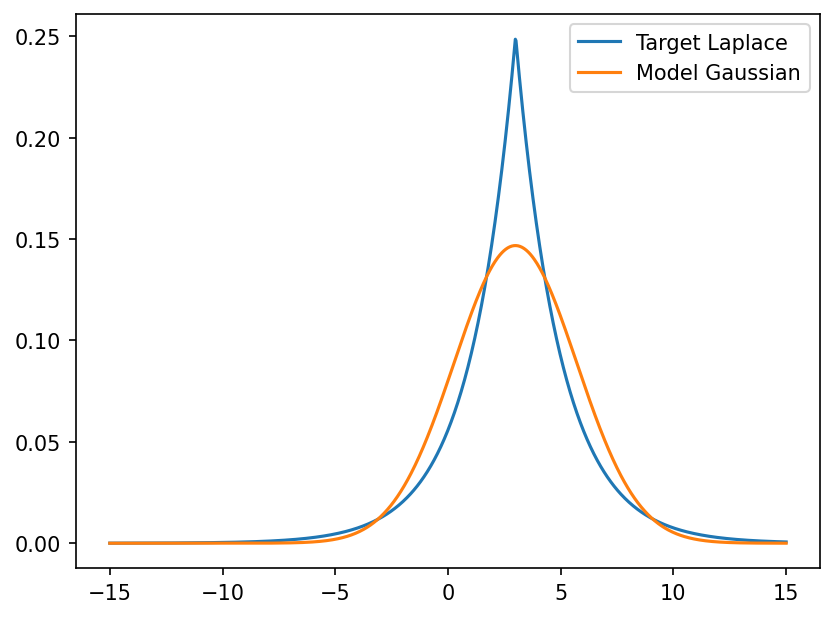

In [98]:
fig, ax = plt.subplots(1, 1, dpi=150)
x = torch.linspace(-15, 15, 1000)[:, None]
with torch.no_grad():
    target_prob = torch.exp(target_distr.log_prob(x))
    model_gaussian_prob = torch.exp(model_gaussian.log_prob(x))
ax.plot(x, target_prob, label='Target Laplace')
ax.plot(x, model_gaussian_prob, label='Model Gaussian')
ax.legend()

It can be seen that Gaussian align with Laplace, but still just cannot be exactly aligned. We will now see if we can improve by using normalizing flow.

### Using normalizing flow

In [33]:
# we are going to use a fixed base distribution of standard normal
flow_base_distr = G.IndependentNormal(torch.Tensor([0]), torch.Tensor([1]))

In [176]:
# we now build flow layers. We are going to primarily stack affine and elu
layers = [
    T.IndependentAffine(1),
    T.ELU(),
    T.IndependentAffine(1),
    T.ELU(),
    T.IndependentAffine(1),
    T.ELU(),
    T.IndependentAffine(1),
    T.ELU(),
    T.IndependentAffine(1),
]

transform = T.SequentialTransform(*layers)

In [177]:
# Initialize the layers
init_std = 0.1
def init_module(module):
    if isinstance(module, T.IndependentAffine):
        module.weight.data.normal_(mean=1.0, std=init_std)
        module.bias.data.normal_(std=init_std * 0.1)

transform.apply(init_module)

SequentialTransform(
  (transforms): ModuleList(
    (0): IndependentAffine()
    (1): ELU()
    (2): IndependentAffine()
    (3): ELU()
    (4): IndependentAffine()
    (5): ELU()
    (6): IndependentAffine()
    (7): ELU()
    (8): IndependentAffine()
  )
)

In [178]:
model_flow = FlowDistribution(flow_base_distr, transform)

#### Before training:

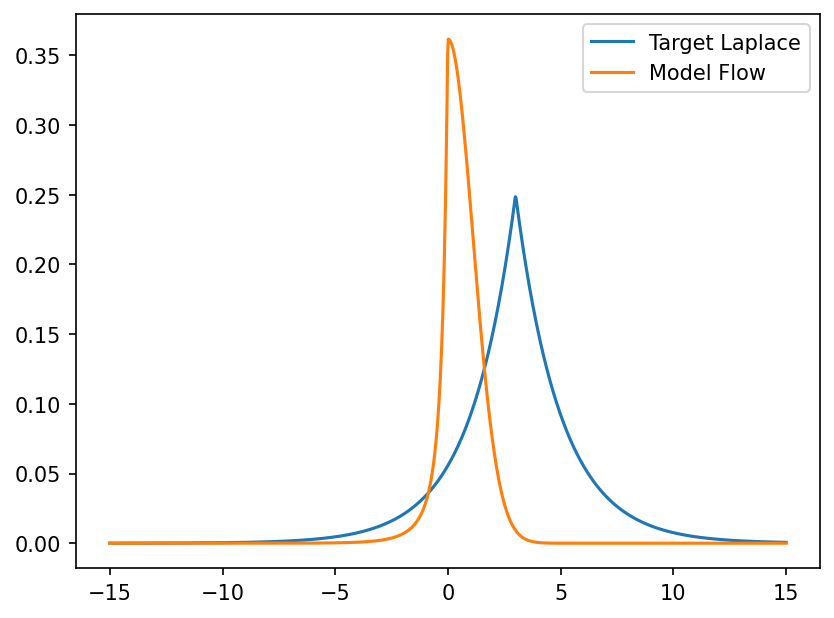

In [179]:
fig, ax = plt.subplots(1, 1, dpi=150)
x = torch.linspace(-15, 15, 1000)[:, None]
with torch.no_grad():
    target_prob = torch.exp(target_distr.log_prob(x))
    model_flow_prob = torch.exp(model_flow.log_prob(x))
ax.plot(x, target_prob, label='Target Laplace')
ax.plot(x, model_flow_prob, label='Model Flow')
ax.legend()

#### Training the normalizing flow

In [188]:
optim = Adam(model_flow.parameters(), lr=0.1)

In [216]:
for _ in range(1000):
    optim.zero_grad()
    nll = -model_flow(target_samples).mean()
    print(f'Model LL: {-nll}, Target LL: {target_logL}')
    nll.backward()
    optim.step()

Model LL: -2.4563674926757812, Target LL: -2.42438006401062
Model LL: -2.4456896781921387, Target LL: -2.42438006401062
Model LL: -2.4484753608703613, Target LL: -2.42438006401062
Model LL: -2.4466443061828613, Target LL: -2.42438006401062
Model LL: -2.4402294158935547, Target LL: -2.42438006401062
Model LL: -2.4527220726013184, Target LL: -2.42438006401062
Model LL: -2.434680223464966, Target LL: -2.42438006401062
Model LL: -2.4509642124176025, Target LL: -2.42438006401062
Model LL: -2.4446842670440674, Target LL: -2.42438006401062
Model LL: -2.4369776248931885, Target LL: -2.42438006401062
Model LL: -2.4487876892089844, Target LL: -2.42438006401062
Model LL: -2.4373388290405273, Target LL: -2.42438006401062
Model LL: -2.43589186668396, Target LL: -2.42438006401062
Model LL: -2.4423835277557373, Target LL: -2.42438006401062
Model LL: -2.431320905685425, Target LL: -2.42438006401062
Model LL: -2.4348325729370117, Target LL: -2.42438006401062
Model LL: -2.436434507369995, Target LL: -2.

#### After training:

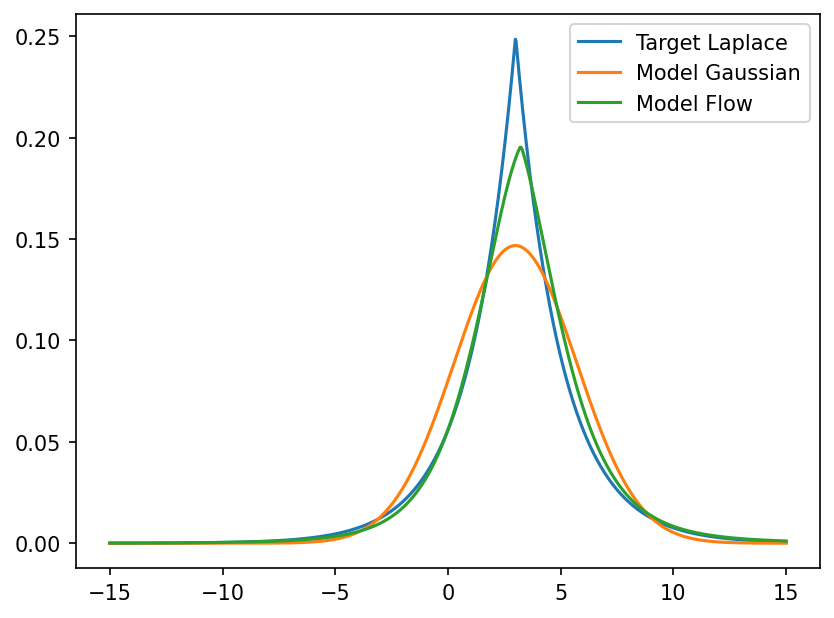

In [217]:
fig, ax = plt.subplots(1, 1, dpi=150)
x = torch.linspace(-15, 15, 1000)[:, None]
with torch.no_grad():
    target_prob = torch.exp(target_distr.log_prob(x))
    model_gaussian_prob = torch.exp(model_gaussian.log_prob(x))
    model_flow_prob = torch.exp(model_flow.log_prob(x))

ax.plot(x, target_prob, label='Target Laplace')
ax.plot(x, model_gaussian_prob, label='Model Gaussian')
ax.plot(x, model_flow_prob, label='Model Flow')
ax.legend()

(-15.0, 15.0)

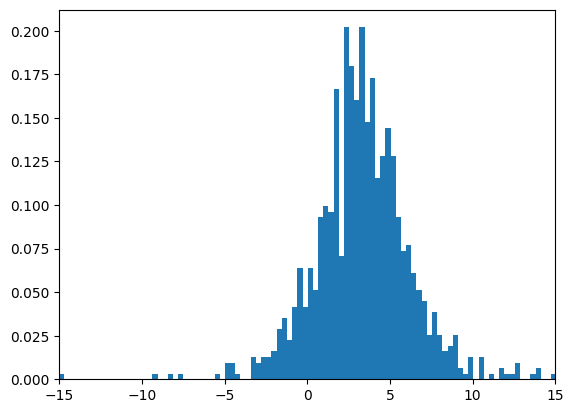

In [218]:
with torch.no_grad():
    model_flow_samples = model_flow.sample((1000,))
plt.hist(model_flow_samples.flatten(), bins=np.linspace(-15,16,100), density=True);
plt.xlim(-15, 15)